# Sommaire :

**Partie 1 : Préparation de l'environnement et présentation des données**
 - <a href="#C1">I-1) Initialisation des librairies</a>
 - <a href="#C2">I-2) Importation et description des données</a>
 
**Partie 2 : Nettoyage du jeu de données**
 - <a href="#C3">II-1) Renommage et récupération des données d'intérêt</a>
 - <a href="#C4">II-2) Gestion des Doublons</a>
 - <a href="#C5">II-3) Gestion des Valeurs manquantes</a>

**Partie 3 : Jointure des 3 tables**

**Partie 4 : Analyse du chiffre d'affaires et des prix des produits**
 - <a href="#C6">IV-1) Analyse du chiffre d'affaires</a>
 - <a href="#C7">IV-2) Analyse des prix de ventes</a>

**Partie 5 : Quelques pistes pour des analyses plus détaillées**
 - <a href="#C8">V-1) Récupération de l'information âge et classe</a>
 - <a href="#C9">V-2) Réprésentations graphiques des données</a>

# **Partie 1 : Préparation de l'environnement et présentation des données**
## <a name="C1">I-1) Initialisation des librairies</a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api
import scipy.stats as stats

## <a name="C2">I-2) Importation et description des données</a>

In [2]:
erp = pd.read_excel('erp.xlsx')
liaison = pd.read_excel('liaison.xlsx')
web = pd.read_excel('web.xlsx')

B:\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [3]:
print(erp.head())
print("_"*60)
print("_"*60)
print(erp.info())

   product_id  onsale_web  price  stock_quantity stock_status
0        3847           1   24.2               0   outofstock
1        3849           1   34.3               0   outofstock
2        3850           1   20.8               0   outofstock
3        4032           1   14.1               0   outofstock
4        4039           1   46.0               0   outofstock
____________________________________________________________
____________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      825 non-null    int64  
 1   onsale_web      825 non-null    int64  
 2   price           825 non-null    float64
 3   stock_quantity  825 non-null    int64  
 4   stock_status    825 non-null    object 
dtypes: float64(1), int64(3), object(1)
memory usage: 32.4+ KB
None


In [4]:
print(liaison.head())
print("_"*40)
print("_"*40)
print(liaison.info())

   product_id id_web
0        3847  15298
1        3849  15296
2        3850  15300
3        4032  19814
4        4039  19815
________________________________________
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  825 non-null    int64 
 1   id_web      734 non-null    object
dtypes: int64(1), object(1)
memory usage: 13.0+ KB
None


In [5]:
print(web.head())
print("_"*100)
print("_"*100)
print(web.info())

                   sku  virtual  downloadable  rating_count  average_rating  \
0  bon-cadeau-25-euros        0             0             0             0.0   
1                15298        0             0             0             0.0   
2                15296        0             0             0             0.0   
3                15300        0             0             0             0.0   
4                19814        0             0             0             0.0   

   total_sales tax_status  tax_class  post_author           post_date  ...  \
0         10.0    taxable        NaN          1.0 2018-06-01 13:53:46  ...   
1          6.0    taxable        NaN          2.0 2018-02-08 12:58:52  ...   
2          0.0    taxable        NaN          2.0 2018-02-08 13:49:41  ...   
3          0.0    taxable        NaN          2.0 2018-02-08 14:08:36  ...   
4          3.0    taxable        NaN          2.0 2018-02-09 14:01:05  ...   

                                           post_name    

On peut observer le détail des différents fichiers :  
- "erp" : 825 lignes et 5 colonnes, qui référence l'id du produit, sa dispo en ligne, son prix et son stock. 
- "liaison" : 825 lignes et 2 colonnes, référençant l'id du produit et sa référence web
- "web" 1513 lignes et 28 colonnes, présentant la référence web du produit, sa date de mise en ligne, son nom et divers autres informations. 

Le type de chaque variable des données est cohérent. Le format des dates est cohérent, suggérant aucune erreur de formatage ou d'irrégularité. 

# **Partie 2 : Nettoyage du jeu de données**


## <a name="C3"> II-1) Renommage et récupération des données d'intérêt</a>

In [6]:
#Selection des variables d'interets dans le fichier web
web_light=web[["sku", "total_sales","post_date", "post_title", "post_name"]].copy()

In [7]:
#Renommage de la colonne 'id_web' dans le fichier 'liaison'.
liaison.rename(columns={'id_web': 'sku'}, inplace=True)
liaison.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  825 non-null    int64 
 1   sku         734 non-null    object
dtypes: int64(1), object(1)
memory usage: 13.0+ KB


In [8]:
#Selection des données concernant les ventes en lignes.
erp[['onsale_web','product_id']].groupby(['onsale_web']).count()

,product_id
onsale_web,
0,108
1,717


Seules les lignes concernant les ventes en lignes nous intéressent. Il faut donc garder les lignes où onsale_web = 1. 

In [9]:
erp=erp[erp.onsale_web == 1]
erp[['onsale_web','product_id']].groupby(['onsale_web']).count()

,product_id
onsale_web,
1,717


## <a name="C4"> II-2) Gestion des Doublons </a>

In [10]:
#Vérification des doublons dans le fichier 'liaison'

liaison.loc[liaison[['product_id', 'sku']].duplicated(keep=False),:]

,product_id,sku


In [11]:
#Vérification des doublons dans le fichier 'erp'
erp.loc[erp[['product_id']].duplicated(keep=False),:]

,product_id,onsale_web,price,stock_quantity,stock_status


In [12]:
#Vérification des doublons dans le fichier 'web'
web_light.loc[web_light[['sku','post_title']].duplicated(keep=False),:]

,sku,total_sales,post_date,post_title,post_name
0,bon-cadeau-25-euros,10.0,2018-06-01 13:53:46,Bon cadeau de 25€,bon-cadeau-de-25-euros
1,15298,6.0,2018-02-08 12:58:52,Pierre Jean Villa Saint-Joseph Préface 2018,pierre-jean-villa-saint-joseph-preface-2018
2,15296,0.0,2018-02-08 13:49:41,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,pierre-jean-villa-saint-joseph-tilde-2017
3,15300,0.0,2018-02-08 14:08:36,Pierre Jean Villa Crozes-Hermitage Accroche Co...,pierre-jean-villa-croze-hermitage-accroche-coe...
4,19814,3.0,2018-02-09 14:01:05,Pierre Jean Villa IGP Collines Rhodaniennes Ga...,pierre-jean-villa-igp-gamine-2018
...,...,...,...,...,...
1508,16135,5.0,2020-04-25 13:22:38,Mouthes Le Bihan Côtes de Duras L'Aimé Chai 2015,mouthes-le-bihan-aime-chai-2015
1509,15891,0.0,2020-05-02 14:53:40,Camin Larredya Jurançon Sec La Virada 2018,camin-larredya-jurancon-sec-la-virada-2018
1510,15887,0.0,2020-05-02 15:00:54,Domaine Jamet Côte Rôtie Fructus Voluptas 2018,jamet-cote-rotie-fructus-voluptas-2018
1511,13127-1,0.0,2020-06-09 15:42:04,Clos du Mont-Olivet Châteauneuf-du-Pape 2007,clos-du-mont-olivet-chateauneuf-du-pape-2007-2


In [13]:
#retrait des doublons dans le fichier 'web'
web_light.drop_duplicates(subset=['sku','post_title'], inplace=True, ignore_index=True)

In [14]:
#vérification du retrait des doublons

print(web_light.info())
print("_"*100)
print("_"*100)
print(web_light.loc[web_light[['sku','post_title']].duplicated(keep=False),:])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   sku          714 non-null    object        
 1   total_sales  716 non-null    float64       
 2   post_date    716 non-null    datetime64[ns]
 3   post_title   716 non-null    object        
 4   post_name    716 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 28.1+ KB
None
____________________________________________________________________________________________________
____________________________________________________________________________________________________
Empty DataFrame
Columns: [sku, total_sales, post_date, post_title, post_name]
Index: []


## <a name="C5"> II-3) Gestion des Valeurs manquantes</a>

In [15]:
#Vérification des valeurs manquantes dans le fichier 'liaison'
liaison.isnull().sum()

product_id     0
sku           91
dtype: int64

In [16]:
#Retrait des valeurs manquantes dans le fichier 'liaison'

liaison.dropna(subset = ["sku"], inplace=True)
liaison.loc[liaison['sku'].isnull(),:]

,product_id,sku


91 lignes disposent de valeurs manquantes dans "sku". Ces valeurs seront retirées par la suite. 

In [17]:
#Vérification des valeurs manquantes dans le fichier 'erp'

erp.isnull().sum()

product_id        0
onsale_web        0
price             0
stock_quantity    0
stock_status      0
dtype: int64

In [18]:
#Vérification des valeurs manquantes dans le fichier 'web'

web_light.isnull().sum()

sku            3
total_sales    1
post_date      1
post_title     1
post_name      1
dtype: int64

In [19]:
#Quelles sont les 3 références sku manquantes ?

web_light.loc[web_light['sku'].isnull(),:]

,sku,total_sales,post_date,post_title,post_name
178,NaN,NaN,NaT,NaN,NaN
449,NaN,0.0,2018-07-31 12:07:23,Pierre Jean Villa Côte Rôtie Fongeant 2017,pierre-jean-villa-cote-rotie-fongeant-2017
450,NaN,0.0,2018-08-08 11:23:43,Pierre Jean Villa Condrieu Jardin Suspendu 2018,pierre-jean-villa-condrieu-suspendu-2018


une ligne est remplie de valeur manquante, mais deux lignes contiennent des références sur le site web avec les détails. En revanche, ces deux lignes ne disposent pas de sku (id du produit). Il ne sera pas possible par la suite de joindre ces lignes avec le fichier liaison et erp. 

In [20]:
#Retrait des valeurs manquantes dans le fichier 'web'

web_light.dropna(subset = ["sku"], inplace=True)
web_light.loc[web_light['sku'].isnull(),:]

,sku,total_sales,post_date,post_title,post_name


# **Partie 3 : Jointure des 3 tables**

In [21]:
#jointure entre 'erp' et 'liaison' sur le 'product_id'

erp_liaison = pd.merge(erp,liaison, on='product_id' )

In [22]:
#jointure entre 'erp_liaison' et 'web' sur le 'sku'

erp_liaison_web = pd.merge(erp_liaison,web_light, on='sku' )

In [23]:
#vérification de la jointure
erp_liaison_web

,product_id,onsale_web,price,stock_quantity,stock_status,sku,total_sales,post_date,post_title,post_name
0,3847,1,24.2,0,outofstock,15298,6.0,2018-02-08 12:58:52,Pierre Jean Villa Saint-Joseph Préface 2018,pierre-jean-villa-saint-joseph-preface-2018
1,3849,1,34.3,0,outofstock,15296,0.0,2018-02-08 13:49:41,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,pierre-jean-villa-saint-joseph-tilde-2017
2,3850,1,20.8,0,outofstock,15300,0.0,2018-02-08 14:08:36,Pierre Jean Villa Crozes-Hermitage Accroche Co...,pierre-jean-villa-croze-hermitage-accroche-coe...
3,4032,1,14.1,0,outofstock,19814,3.0,2018-02-09 14:01:05,Pierre Jean Villa IGP Collines Rhodaniennes Ga...,pierre-jean-villa-igp-gamine-2018
4,4039,1,46.0,0,outofstock,19815,0.0,2018-02-12 09:04:37,Pierre Jean Villa Côte Rôtie Carmina 2017,pierre-jean-villa-cote-rotie-carmina-2017
...,...,...,...,...,...,...,...,...,...,...
709,6930,1,8.4,83,instock,16135,5.0,2020-04-25 13:22:38,Mouthes Le Bihan Côtes de Duras L'Aimé Chai 2015,mouthes-le-bihan-aime-chai-2015
710,7023,1,27.5,15,instock,15891,0.0,2020-05-02 14:53:40,Camin Larredya Jurançon Sec La Virada 2018,camin-larredya-jurancon-sec-la-virada-2018
711,7025,1,69.0,2,instock,15887,0.0,2020-05-02 15:00:54,Domaine Jamet Côte Rôtie Fructus Voluptas 2018,jamet-cote-rotie-fructus-voluptas-2018
712,7247,1,54.8,23,instock,13127-1,0.0,2020-06-09 15:42:04,Clos du Mont-Olivet Châteauneuf-du-Pape 2007,clos-du-mont-olivet-chateauneuf-du-pape-2007-2


# **Partie 4 : Analyse du chiffre d'affaires et des prix des produits**

## <a name="C6">IV-1) Analyse du chiffre d'affaires</a>

### Récupération du chiffre d'affaires par produit et somme totale

In [24]:
erp_liaison_web["CA_produit"] = (erp_liaison_web["total_sales"] * erp_liaison_web["price"])
print(erp_liaison_web["CA_produit"])

0      145.2
1        0.0
2        0.0
3       42.3
4        0.0
       ...  
709     42.0
710      0.0
711      0.0
712      0.0
713      0.0
Name: CA_produit, Length: 714, dtype: float64


In [25]:
erp_liaison_web["CA_produit"].sum()

70568.6

### Courbe de Lorenz

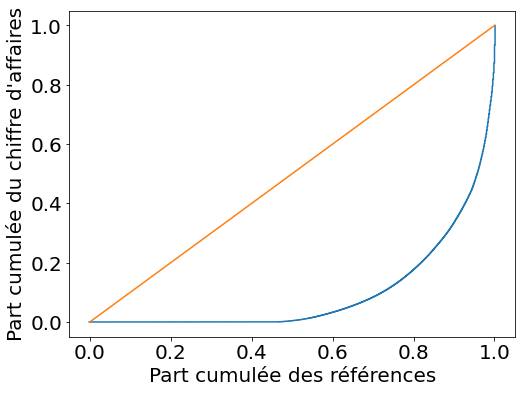

L'indice de gini est de : 0.81


In [26]:

CA_produit = erp_liaison_web['CA_produit'].values
n = len(CA_produit)
lorenz = np.cumsum(np.sort(CA_produit)) / CA_produit.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams.update({'font.size': 20})
xaxis = np.linspace(0-1/n,1+1/n,len(lorenz)) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.plot([0,1], [0,1]) #tracer la bisséctrice
plt.xlabel("Part cumulée des références")
plt.ylabel("Part cumulée du chiffre d'affaires")
plt.show()

#Calcul de l'indice de Gini, allant de 0 (égalité entre les références) à 1 (inégalité entre les références)
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = 2*S
print("L'indice de gini est de :",round(gini,2))

Un indice de Gini de 0.81 indique une forte inégalité dans la répartition du chiffre d'affaires. En effet, grâce à la courbe de Lorenz, on peut visualiser que 80% du chiffre d'affaires totale a été réalisé par seulement 20% des références. 

## <a name="C7">IV-2) Analyse des prix de ventes</a>

### Résumé et valeurs clés des données de prix : 

In [27]:
#résumé des informations clés des données de prix 
round(erp_liaison_web["price"].describe(),2)

count    714.00
mean      32.49
std       27.81
min        5.20
25%       14.10
50%       23.55
75%       42.18
max      225.00
Name: price, dtype: float64

Le jeu de donnée comporte 714 lignes (références) dont le prix moyen est de 32.49€. La référence la moins chère à un prix de 5.20 € alors que la plus chère est de 225 €. Le prix médian est de 23.55 €.
Nous pouvons voir ci-dessous la référence la moins chère et la plus chère :

In [28]:
print("La référence la moins chère : ")
erp_liaison_web[(erp_liaison_web.price == 5.20)]

La référence la moins chère : 


,product_id,onsale_web,price,stock_quantity,stock_status,sku,total_sales,post_date,post_title,post_name,CA_produit
645,6129,1,5.2,30,instock,14570,0.0,2019-06-28 18:01:06,Moulin de Gassac IGP Pays d'Hérault Guilhem Bl...,moulin-de-gassac-igp-pays-dherault-guilhem-bla...,0.0


In [29]:
print("La référence la plus chère : ")
erp_liaison_web[(erp_liaison_web.price == 225.00)]

La référence la plus chère : 


,product_id,onsale_web,price,stock_quantity,stock_status,sku,total_sales,post_date,post_title,post_name,CA_produit
199,4352,1,225.0,0,outofstock,15940,5.0,2018-03-02 10:30:04,Champagne Egly-Ouriet Grand Cru Millésimé 2008,champagne-egly-ouriet-grand-cru-millesime-2008,1125.0


### Réprésentation graphique : histogramme des prix

<AxesSubplot:xlabel='price', ylabel='Count'>

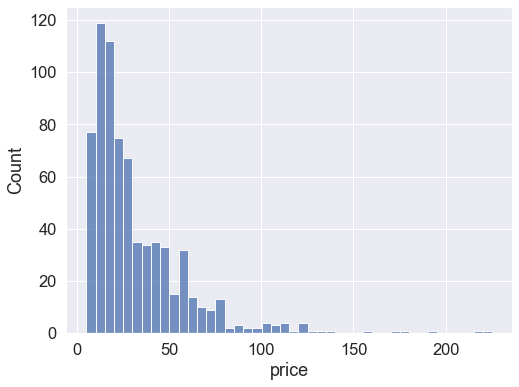

In [30]:
plt.rcParams["figure.figsize"] = (8,6)

sns.set(font_scale=1.5)
sns.histplot(data=erp_liaison_web, x="price",binwidth=5)

On constate sur cet histogramme que certains produits ont un prix beaucoup plus élevé que les autres, pouvant affecter la moyenne des prix de ventes. Nous allons voir par la suite comment repérer ses références extrêmes en utilisant la méthode de la distance interquartile. 

In [31]:
PremQ=erp_liaison_web["price"].describe()[4] # Cette ligne récupère la valeur du premier quartile
TroisQ= erp_liaison_web["price"].describe()[6] # Cette ligne récupère la valeur du troisème quartile
EcartIQ=TroisQ-PremQ # Cette ligne crée l'écart Inter-quartile
print(PremQ,TroisQ,EcartIQ)

14.1 42.175000000000004 28.075000000000003


In [32]:
# vérification des références sous le seuil inférieur 
erp_liaison_web[(erp_liaison_web.price < PremQ - 1.5*EcartIQ)].count()

product_id        0
onsale_web        0
price             0
stock_quantity    0
stock_status      0
sku               0
total_sales       0
post_date         0
post_title        0
post_name         0
CA_produit        0
dtype: int64

Il n'y a pas de référence dont le prix est bien inférieur à la majorité des références. 

In [33]:
# vérification des références au dessus du seuil supérieur 

erp_liaison_web[(erp_liaison_web.price > TroisQ + 1.5*EcartIQ)].count()
# print(erp_liaison_web[(erp_liaison_web.price > TroisQ + 1.5*EcartIQ)])

product_id        32
onsale_web        32
price             32
stock_quantity    32
stock_status      32
sku               32
total_sales       32
post_date         32
post_title        32
post_name         32
CA_produit        32
dtype: int64

Il y a 32 références dont le prix est majoritairement supérieur à la majorité des références. 

### Filtre des valeurs extrêmes : 

On peut filtrer ces références pour regarder la moyenne des prix de la majorité des références : 

In [34]:
erp_liaison_web_F=erp_liaison_web[(erp_liaison_web.price > PremQ - 1.5*EcartIQ) & (erp_liaison_web.price < TroisQ + 1.5*EcartIQ)].copy()

<AxesSubplot:xlabel='price', ylabel='Count'>

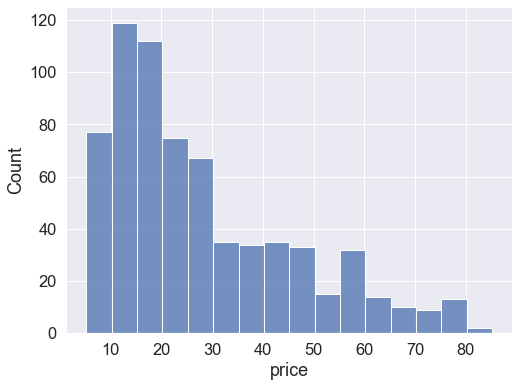

In [35]:
plt.rcParams["figure.figsize"] = (8,6)
sns.set(font_scale=1.5)
sns.histplot(data=erp_liaison_web_F, x="price",binwidth=5)

In [36]:
#résumé des informations clés de la majorité des données de prix

round(erp_liaison_web_F["price"].describe(),2)

count    682.00
mean      28.17
std       18.26
min        5.20
25%       13.70
50%       22.80
75%       39.00
max       83.70
Name: price, dtype: float64

Il y a désormais 682 références, dont la moyenne des prix est de 28,17 €. le prix minimal est toujours de 5.20€, et le prix maximale est désormais de 83.70€. Le prix médian est de 22.80€.

Cependant, les valeurs extrêmes observées précédemment ne sont pas "aberrantes", il s'agit juste de bouteilles dont le prix est réellement plus élevé. Pour la suite des analyses, nous conserverons donc ces valeurs !

# **Partie 5 : Quelques pistes pour des analyses plus détaillées**

## <a name="C8">V-1) Récupération de l'information âge et classe</a>

Pour allez un petit peu plus loin aves les données, nous pouvons récupérer l'âge des bouteilles et leur classe (vin, champagne, spiritueux) à partir de leur nom. Pour cela, nous allons nous servir de la colonne post_name, dont toutes les informations sont présentes en lettre minuscule, favorisant les recherches textuelles.

In [37]:
# Cette boucle 'for' ajoute l'âge des références si l'année apparait dans leur nom. 
annee = pd.Series(np.arange(1980,2021,1))
for annee in annee:
    erp_liaison_web.loc[erp_liaison_web['post_name'].str.contains(str(annee)), 'age'] = str(annee)

In [38]:
print(erp_liaison_web[['age','post_name']]) # Vérification si la colonne age correspond à l'age dans le titre de la référence  
print("_"*100)
print("_"*100)
erp_liaison_web.info() # Vérification du type et du nombre de référence avec un age.  

      age                                          post_name
0    2018        pierre-jean-villa-saint-joseph-preface-2018
1    2017          pierre-jean-villa-saint-joseph-tilde-2017
2    2018  pierre-jean-villa-croze-hermitage-accroche-coe...
3    2018                  pierre-jean-villa-igp-gamine-2018
4    2017          pierre-jean-villa-cote-rotie-carmina-2017
..    ...                                                ...
709  2015                    mouthes-le-bihan-aime-chai-2015
710  2018         camin-larredya-jurancon-sec-la-virada-2018
711  2018             jamet-cote-rotie-fructus-voluptas-2018
712  2007     clos-du-mont-olivet-chateauneuf-du-pape-2007-2
713  2019  domaine-saint-nicolas-fiefs-vendeens-blanc-les...

[714 rows x 2 columns]
____________________________________________________________________________________________________
____________________________________________________________________________________________________
<class 'pandas.core.frame.DataFrame'>
Int6

On a donc pu récupérer l'âge de 650 références sur les 714.

In [39]:
# Les lignes suivantes attribut une classe à chaque référence (Vin, spiritueux ou champagne) a chaque référence 
# lorsque celle-ci en fait mention. 
erp_liaison_web['classe']='Vin'
erp_liaison_web.loc[erp_liaison_web['post_name'].str.contains('cognac'), 'classe'] = 'Spiritueux'
erp_liaison_web.loc[erp_liaison_web['post_name'].str.contains('whisky'), 'classe'] = 'Spiritueux'
erp_liaison_web.loc[erp_liaison_web['post_name'].str.contains('champagne'), 'classe'] = 'Champagne'

In [40]:
# compte du nombre de référence de la classe "vin" 
erp_liaison_web.loc[erp_liaison_web['classe'].str.contains('Vin')].count()

product_id        666
onsale_web        666
price             666
stock_quantity    666
stock_status      666
sku               666
total_sales       666
post_date         666
post_title        666
post_name         666
CA_produit        666
age               635
classe            666
dtype: int64

Il y a 666 référence de vin, dont 635 avec un âge associé.

In [41]:
# compte du nombre de référence de la classe "Champagne" 

erp_liaison_web.loc[erp_liaison_web['classe'].str.contains('Champagne')].count()

product_id        27
onsale_web        27
price             27
stock_quantity    27
stock_status      27
sku               27
total_sales       27
post_date         27
post_title        27
post_name         27
CA_produit        27
age               12
classe            27
dtype: int64

Il y a 27 références de champagne, dont 12 avec un âge associé.

In [42]:
# compte du nombre de référence de la classe "Spiritueux" 

erp_liaison_web.loc[erp_liaison_web['classe'].str.contains('Spiritueux')].count()

product_id        21
onsale_web        21
price             21
stock_quantity    21
stock_status      21
sku               21
total_sales       21
post_date         21
post_title        21
post_name         21
CA_produit        21
age                3
classe            21
dtype: int64

Il y a 21 références de spiritueux, dont 3 avec un âge associé.

## <a name="C9">V-2) Réprésentations graphiques des données</a>

### Le prix et le chiffre d'affaires en fonction des différentes catégories d'âge

In [43]:
#Cette ligne permet de récupérer les références où le chiffre d'affaires n'est pas nul. 
ELW_CAnotNull=erp_liaison_web[erp_liaison_web['CA_produit'] != 0] 

Text(0, 0.5, 'Prix (€)')

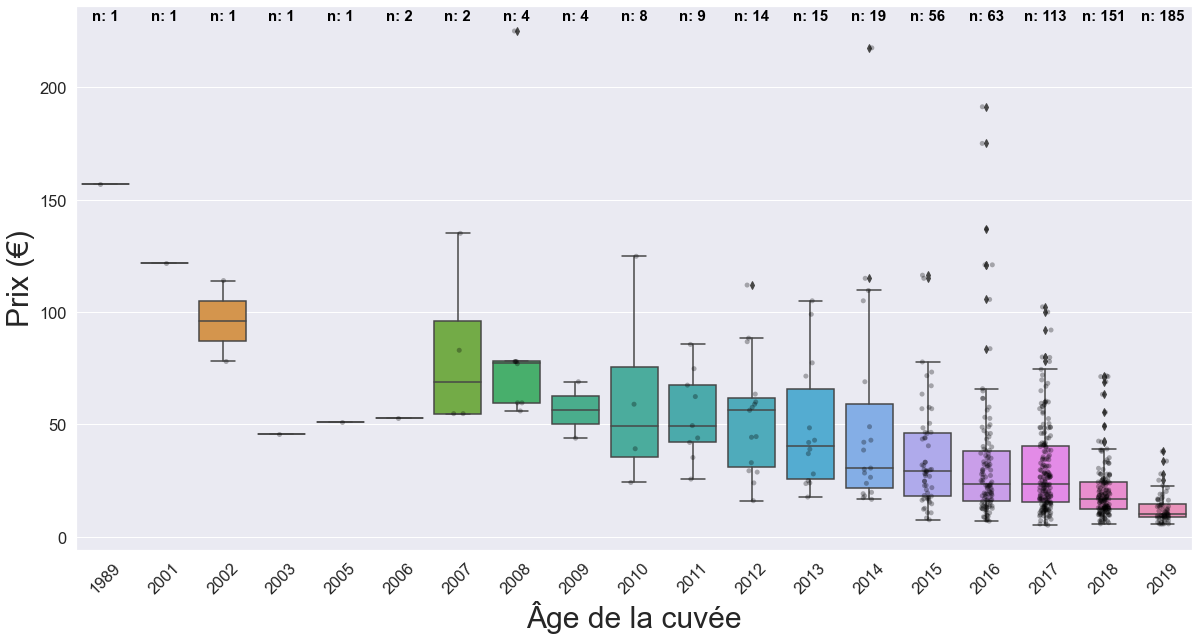

In [44]:
plt.rcParams["figure.figsize"] = (20,10)
sns.set(font_scale=1.5)
ax=sns.boxplot(x="age", y="price", data=erp_liaison_web.sort_values(by="age"))
ax.tick_params(axis='x', rotation=45)




sns.stripplot(x = 'age',
              y = "price",
              color = 'black',
              alpha = 0.3,
              data = erp_liaison_web.sort_values(by="age"))


# Récupération et représentation des effectifs par âge : 
nobs = erp_liaison_web['age'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
nobs = nobs[::-1]

pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
            230,
            nobs[tick],
            horizontalalignment='center',
            size='small',
            color='black',
            weight='semibold')

ax.set_xlabel("Âge de la cuvée", fontsize = 30)
ax.set_ylabel("Prix (€)", fontsize = 30)


Text(0, 0.5, "Chiffre d'affaires (€)")

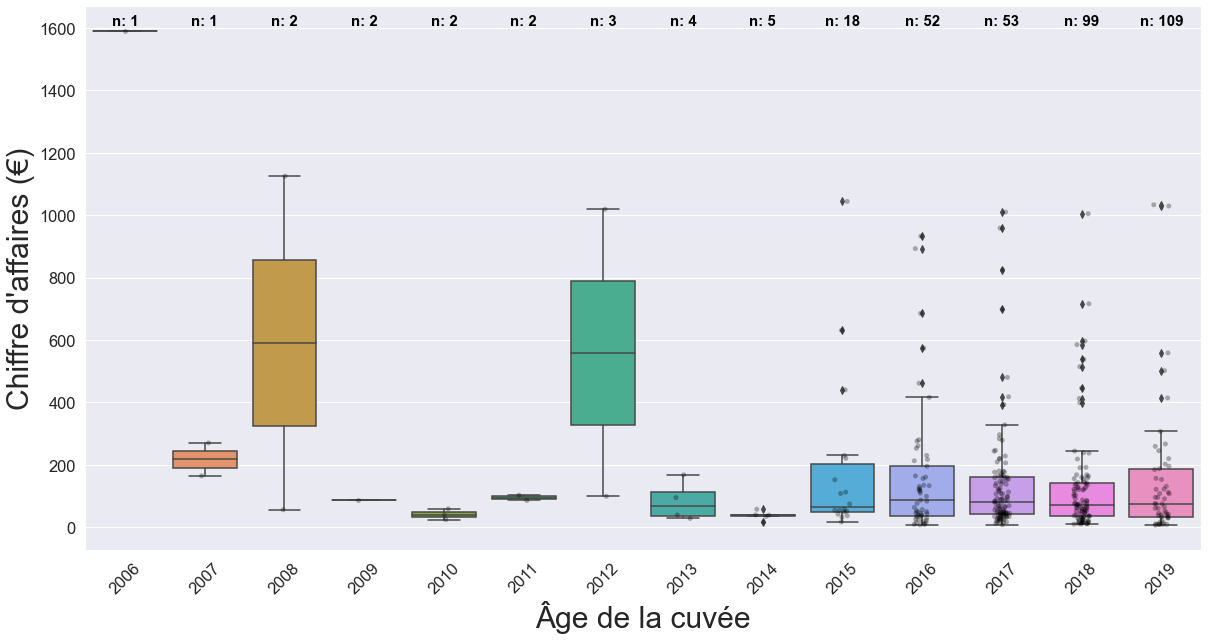

In [45]:
plt.rcParams["figure.figsize"] = (20,10)
sns.set(font_scale=1.5)
ax=sns.boxplot(x="age", y="CA_produit", data=ELW_CAnotNull.sort_values(by="age"))
ax.tick_params(axis='x', rotation=45)



sns.stripplot(x = 'age',
              y = "CA_produit",
              color = 'black',
              alpha = 0.3,
              data = ELW_CAnotNull.sort_values(by="age"))


# Récupération et représentation des effectifes par âge : 
nobs = ELW_CAnotNull['age'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
nobs = nobs[::-1]

pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
            1610,
            nobs[tick],
            horizontalalignment='center',
            size='small',
            color='black',
            weight='semibold')

ax.set_xlabel("Âge de la cuvée", fontsize = 30)
ax.set_ylabel("Chiffre d'affaires (€)", fontsize = 30)


### Le prix et le chiffre d'affaires en fonction de l'âge (variable continue)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(price)   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     228.7
Date:                Wed, 02 Mar 2022   Prob (F-statistic):           1.78e-44
Time:                        10:10:22   Log-Likelihood:                -601.08
No. Observations:                 650   AIC:                             1206.
Df Residuals:                     648   BIC:                             1215.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           271.0814     17.716     15.301      0.000     236.294     305.869
age.astype(float)    -0.1329      0.009    -15.123      0.000      -0.150      -0.116
==============================================================================
Omnibus:                       15.973   Durbin-Watson:                   1.104
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.673
Skew:                           0.392   Prob(JB):                     0.000240
Kurtosis:                       3.025   Cond. No.                     1.49e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

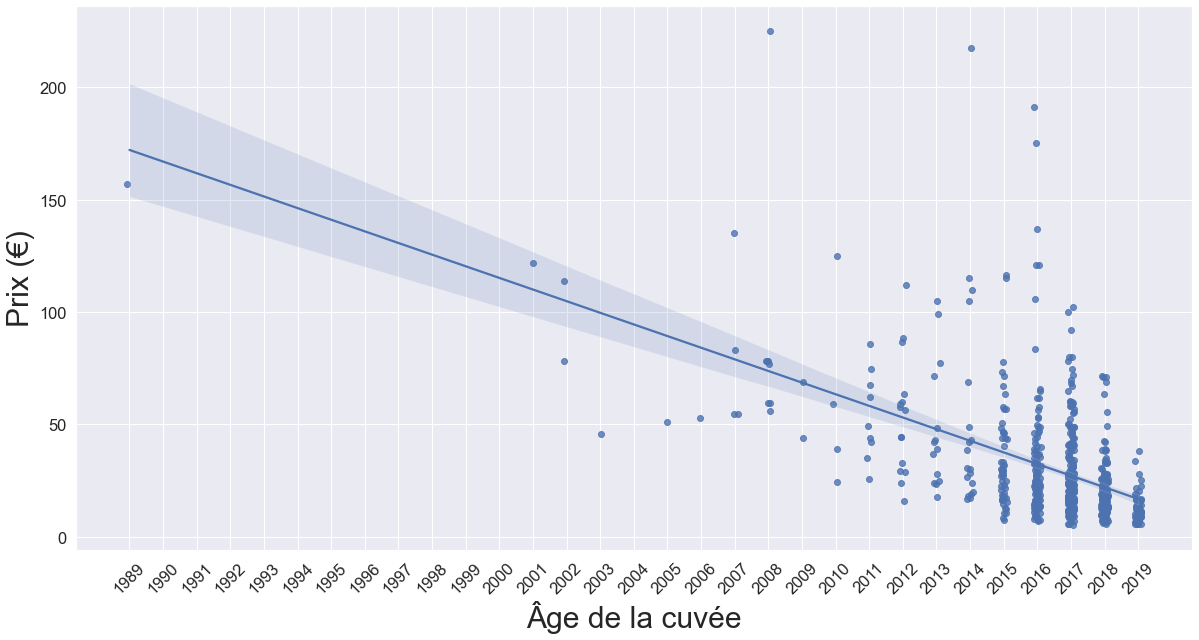

In [46]:
plt.rcParams["figure.figsize"] = (20,10)

ax=sns.regplot(x=erp_liaison_web['age'].dropna().astype(int), y=erp_liaison_web.dropna(subset=["age"], how='all')['price'] ,x_jitter=.1)
ax.tick_params(axis='x', rotation=45)
ax.set(xticks=list(range(1989,2020)))
ax.set_xlabel("Âge de la cuvée", fontsize = 30)
ax.set_ylabel("Prix (€)", fontsize = 30)

# Les lignes facultatives ci-dessous décrivent un test statistique pour quantifier l'effet de l'âge sur le prix.
model = statsmodels.formula.api.ols('np.log(price) ~ age.astype(float)', data = erp_liaison_web)
result = model.fit()
statsmodels.api.stats.anova_lm(result,typ=2)
result.summary() # activez pour observer le résumé détaillé du modèle.

B:\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


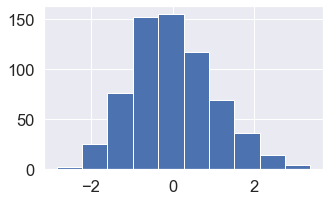

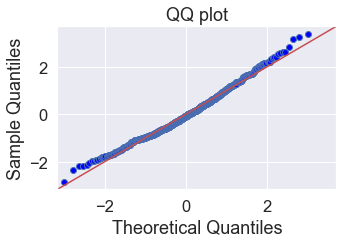

In [55]:
plt.rcParams["figure.figsize"] = (5,3)

residues = result.resid_pearson
residues_std = residues/np.sqrt(sum(residues**2)/(len(residues)-1))

plt.hist(residues_std)

sm.qqplot(residues_std, stats.t, fit=True,line='45')
plt.title("QQ plot")
plt.show()


Text(0, 0.5, "Chiffre d'affaires (€)")

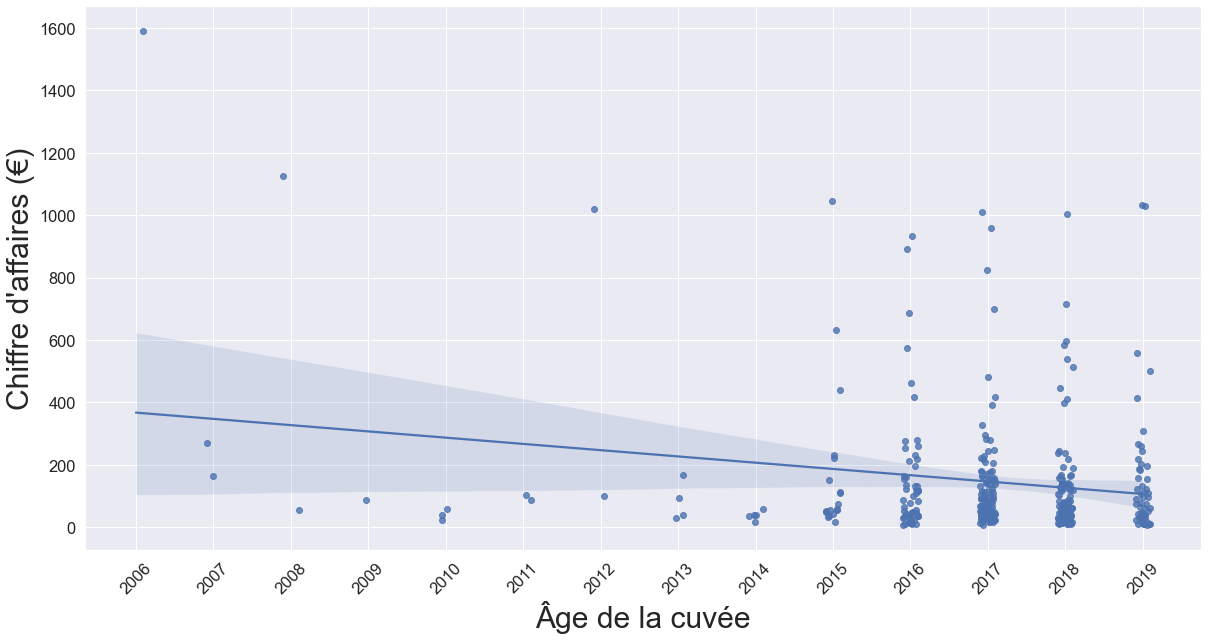

In [48]:
plt.rcParams["figure.figsize"] = (20,10)
ax=sns.regplot(x=ELW_CAnotNull['age'].dropna().astype(int), y=ELW_CAnotNull.dropna(subset=["age"], how='all')['CA_produit'] ,x_jitter=.1)
ax.tick_params(axis='x', rotation=45)
ax.set(xticks=list(range(2006,2020)))

ax.set_xlabel("Âge de la cuvée", fontsize = 30)
ax.set_ylabel("Chiffre d'affaires (€)", fontsize = 30)

# Les lignes facultatives ci-dessous décrivent un test statistique pour quantifier l'effet de l'âge sur le CA.
#model = statsmodels.formula.api.ols('np.log(CA_produit) ~ age.astype(float)', data = ELW_CAnotNull)
#result = model.fit()
#statsmodels.api.stats.anova_lm(result,typ=2)
#result.summary() # activez pour observer le résumé détaillé du modèle.

In [49]:
# Les lignes ci-dessous permettent de visualiser les conditions d'application du modèle linéaire précédent. 

#plt.rcParams["figure.figsize"] = (10,8)

#residues = result.resid_pearson
#residues_std = residues/np.sqrt(sum(residues**2)/(len(residues)-1))
#plt.hist(residues_std)

#sm.qqplot(residues_std, stats.t, fit=True,line='45')
#plt.title("QQ plot")
#plt.show()


### Le prix et le chiffre d'affaires en fonction des différentes classes de bouteille

Text(0, 0.5, 'Prix (€)')

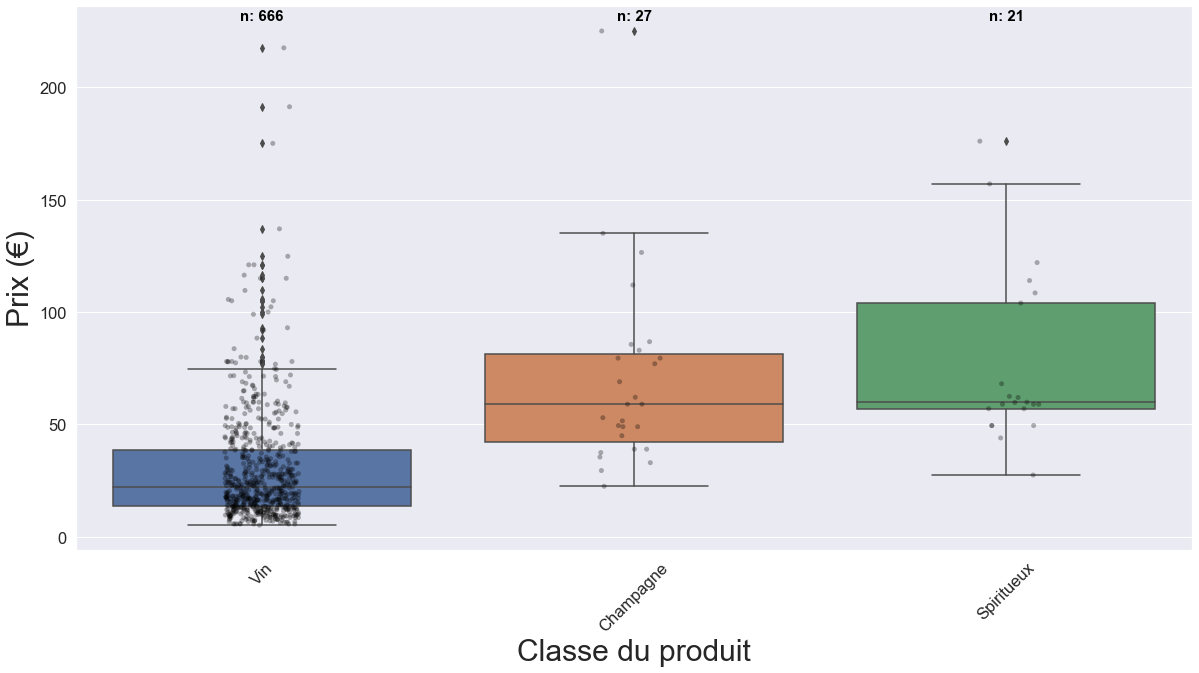

In [50]:
plt.rcParams["figure.figsize"] = (20,10)
sns.set(font_scale=1.5)
ax=sns.boxplot(x='classe', y="price", data=erp_liaison_web)
ax.tick_params(axis='x', rotation=45)


sns.stripplot(x = 'classe',
              y = "price",
              color = 'black',
              alpha = 0.3,
              data = erp_liaison_web)

nobs = erp_liaison_web['classe'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]

pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
            230,
            nobs[tick],
            horizontalalignment='center',
            size='small',
            color='black',
            weight='semibold')
    
ax.set_xlabel("Classe du produit", fontsize = 30)
ax.set_ylabel("Prix (€)", fontsize = 30)

Text(0.5, 0, 'Classe du produit')

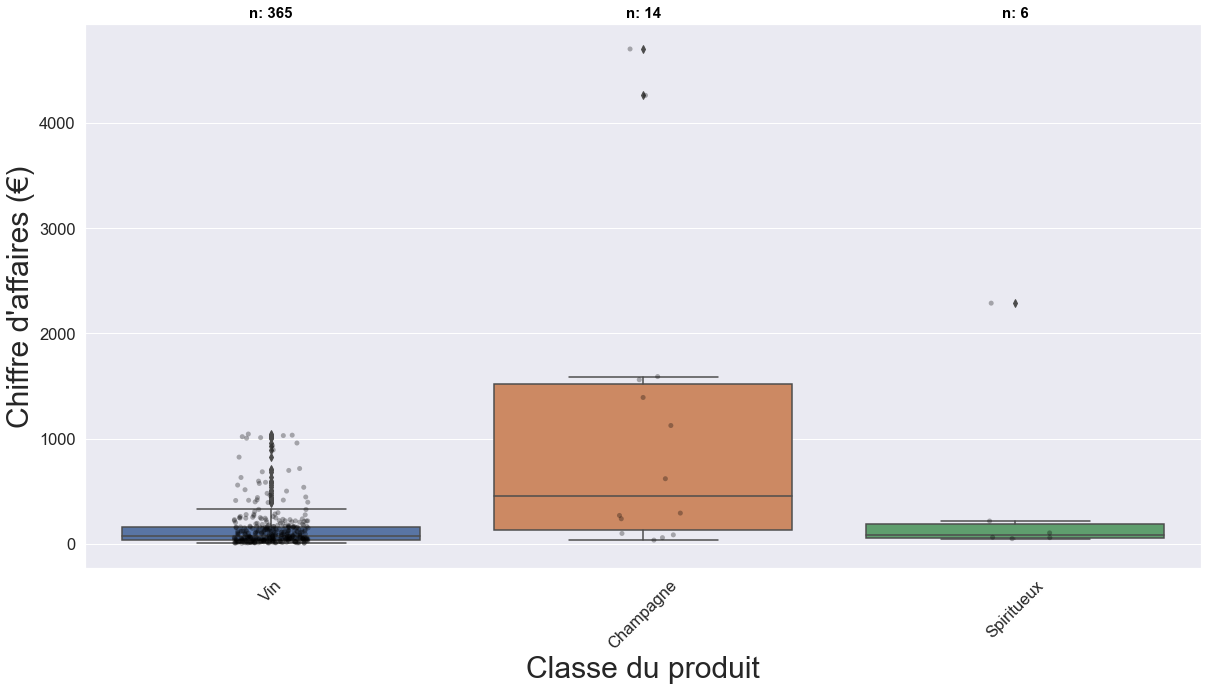

In [51]:
plt.rcParams["figure.figsize"] = (20,10)
sns.set(font_scale=1.5)
ax=sns.boxplot(x='classe', y="CA_produit", data=ELW_CAnotNull)
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("Type de produit", fontsize = 30)
ax.set_ylabel("Prix (€)", fontsize = 30)

sns.stripplot(x = 'classe',
              y = "CA_produit",
              color = 'black',
              alpha = 0.3,
              data = ELW_CAnotNull)

nobs = ELW_CAnotNull['classe'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]

pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick],
            5000,
            nobs[tick],
            horizontalalignment='center',
            size='small',
            color='black',
            weight='semibold')
    
ax.set_ylabel("Chiffre d'affaires (€)", fontsize = 30)
ax.set_xlabel("Classe du produit", fontsize = 30)

In [52]:
# Calcul de la somme du chiffre d'affaires par âge de chaque référence
print(ELW_CAnotNull.groupby(['age'])['CA_produit'].count())
print()
print()
print(ELW_CAnotNull.groupby(['age'])['CA_produit'].sum())


age
2006      1
2007      2
2008      2
2009      1
2010      3
2011      2
2012      2
2013      4
2014      5
2015     18
2016     53
2017    109
2018     99
2019     52
Name: CA_produit, dtype: int64


age
2006     1590.0
2007      434.4
2008     1181.0
2009       87.8
2010      122.4
2011      188.4
2012     1117.9
2013      329.8
2014      187.3
2015     3406.9
2016     8468.5
2017    14621.0
2018    12487.1
2019     7854.4
Name: CA_produit, dtype: float64


In [53]:
# Calcul de la somme du chiffre d'affaires par la classe de chaque référence
print(ELW_CAnotNull.groupby(['classe'])['CA_produit'].count())
print()
print()
print(ELW_CAnotNull.groupby(['classe'])['CA_produit'].sum())

classe
Champagne      14
Spiritueux      6
Vin           365
Name: CA_produit, dtype: int64


classe
Champagne     16332.8
Spiritueux     2780.0
Vin           51455.8
Name: CA_produit, dtype: float64


In [54]:
# Calcul de la somme du chiffre d'affaires par l'age et la classe de chaque référence
print(ELW_CAnotNull.groupby(['age','classe'])['CA_produit'].count())
print()
print()
print(ELW_CAnotNull.groupby(['age','classe'])['CA_produit'].sum())

age   classe   
2006  Champagne      1
2007  Champagne      1
      Vin            1
2008  Champagne      1
      Vin            1
2009  Vin            1
2010  Champagne      1
      Vin            2
2011  Champagne      1
      Vin            1
2012  Champagne      1
      Vin            1
2013  Vin            4
2014  Vin            5
2015  Vin           18
2016  Vin           53
2017  Vin          109
2018  Vin           99
2019  Vin           52
Name: CA_produit, dtype: int64


age   classe   
2006  Champagne     1590.0
2007  Champagne      270.0
      Vin            164.4
2008  Champagne     1125.0
      Vin             56.0
2009  Vin             87.8
2010  Champagne       59.0
      Vin             63.4
2011  Champagne       85.6
      Vin            102.8
2012  Champagne       99.0
      Vin           1018.9
2013  Vin            329.8
2014  Vin            187.3
2015  Vin           3406.9
2016  Vin           8468.5
2017  Vin          14621.0
2018  Vin          12487.1
2019  Vin   